In [2]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [3]:
## FROM MODEL.PY
import torch
import torch.nn as nn
from torch.autograd import Variable

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [4]:
## FROM HELPERS.PY
import unidecode
import string
import random
import time
import math
import torch

# Reading and un-unicode-encoding data

all_characters = string.printable
n_characters = len(all_characters)

def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

# Turning a string into a tensor

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [5]:
## FROM GENERATE.PY
import torch
import os
import argparse

def generate(decoder, prime_str, predict_len=100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    if cuda:
        hidden = hidden.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.cuda()

    return predicted

In [6]:
# Perplexity calculation
def perplexity(loss):
    return 2**loss

Training for 200 epochs...


 50%|█████     | 100/200 [01:21<01:29,  1.11it/s]

 21s (100 50%) 1.7894]
Wher of I'll we to pradight and be o pear take hath from this strence:
This the loath with me are the  


100%|██████████| 200/200 [02:53<00:00,  1.15it/s]

 53s (200 100%) 1.5522]
Where of a more bright.

ROMEO:
At seeen mints advaliers to any may tell;
Whike thou art faress may st 
Saving...
Saved as shakespeare.pt

perplexity is
[tensor(24.3150), tensor(19.3425), tensor(11.8033), tensor(10.4517), tensor(9.8372), tensor(9.1684), tensor(8.9448), tensor(8.1012), tensor(7.5972), tensor(7.2081), tensor(6.8638), tensor(6.7137), tensor(6.3423), tensor(6.1527), tensor(5.9879), tensor(5.8104), tensor(5.6629), tensor(5.6519), tensor(5.5237), tensor(5.4654), tensor(5.3385), tensor(5.2025), tensor(5.1481), tensor(5.1292), tensor(5.0006), tensor(5.1069), tensor(4.9084), tensor(4.8732), tensor(4.8518), tensor(4.7422), tensor(4.7188), tensor(4.6679), tensor(4.7093), tensor(4.5553), tensor(4.6352), tensor(4.5466), tensor(4.5124), tensor(4.4383), tensor(4.3761), tensor(4.3689), tensor(4.4290), tensor(4.3747), tensor(4.3353), tensor(4.3607), tensor(4.2341), tensor(4.1709), tensor(4.1769), tensor(4.1670), tensor(4.1244), tensor(4.1362), tensor(4.0763), te

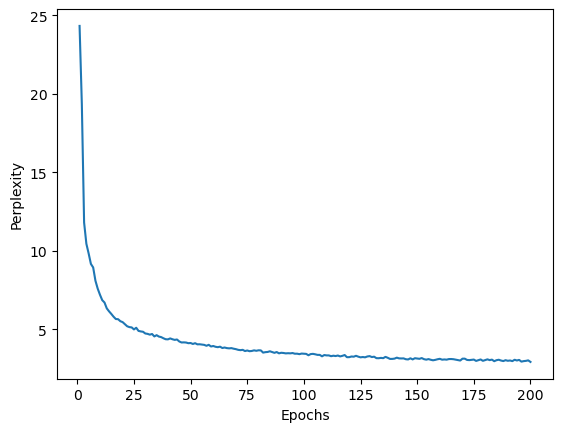

In [10]:
## FROM TRAIN.PY
import torch
import torch.nn as nn
from torch.autograd import Variable
import argparse
import os

from tqdm import tqdm


# Parse command line arguments
argparser = argparse.ArgumentParser()
# argparser.add_argument('filename', type=str, default="shakespeare.txt")
argparser.add_argument('--model', type=str, default="gru")
argparser.add_argument('--n_epochs', type=int, default=200)
argparser.add_argument('--print_every', type=int, default=100)
argparser.add_argument('--hidden_size', type=int, default=100)
argparser.add_argument('--n_layers', type=int, default=2)
argparser.add_argument('--learning_rate', type=float, default=0.01)
argparser.add_argument('--chunk_len', type=int, default=200)
argparser.add_argument('--batch_size', type=int, default=100)
argparser.add_argument('--shuffle', action='store_true')
argparser.add_argument('--cuda', action='store_true')
# edited
args = argparser.parse_args("")

if args.cuda:
    print("Using CUDA")

file, file_len = read_file("shakespeare.txt")

def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    if args.cuda:
        inp = inp.cuda()
        target = target.cuda()
    return inp, target

def train(inp, target):
    hidden = decoder.init_hidden(args.batch_size)
    if args.cuda:
        hidden = hidden.cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(args.chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(args.batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()
    # edited
    return loss.data / args.chunk_len

def save():
    save_filename = os.path.splitext(os.path.basename("shakespeare.txt"))[0] + '.pt'
    torch.save(decoder, save_filename)
    print('Saved as %s' % save_filename)

# Initialize models and start training

decoder = CharRNN(
    n_characters,
    args.hidden_size,
    n_characters,
    model=args.model,
    n_layers=args.n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()

if args.cuda:
    decoder.cuda()

start = time.time()
all_losses = []
loss_avg = 0
epochs = []
perplexitys = []

try:
    print("Training for %d epochs..." % args.n_epochs)
    for epoch in tqdm(range(1, args.n_epochs + 1)):
        loss = train(*random_training_set(args.chunk_len, args.batch_size))
        epochs.append(epoch)
        perplexitys.append(perplexity(loss))
        loss_avg += loss

        if epoch % args.print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / args.n_epochs * 100, loss))
            print(generate(decoder, 'Wh', 100, cuda=args.cuda), '\n', end='\r')

    print("Saving...")
    save()

except KeyboardInterrupt:
    print("Saving before quit...")
    save()


plt.plot(epochs, perplexitys)
print("\nperplexity is")
print(perplexitys)
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.show()

In [11]:
decoder = torch.load("shakespeare.pt")
print(generate(decoder, "abcde"))
print("\n\n")
print(generate(decoder, "8iTch"))
print("\n\n")
print(generate(decoder, "The"))
print("\n\n")
print(generate(decoder, "What is"))
print("\n\n")
print(generate(decoder, "Shall I give"))
print("\n\n")
print(generate(decoder, "X087hNYB BHN BYFVuhsdbs"))


abcdery
And not please earther
Of most been noble they more her for Gerish, and this,
What be callant and



8iTch her to preaver.

DUKE VINCENTIO:
And and have may I hath herebping imbrout when
And they fally and 



The in your are so heak.

HERMIONE:
'Tis quies powern then, bund in thy stays that compents:
Feal we wa



What is come, good son usible
she best on unlace and thence, and feery
For I cornforsy, and a beture you sp



Shall I give of there'' think,
We should soon and is, use; and thou they let shall not fair,
That the true thoin



X087hNYB BHN BYFVuhsdbs your ween a danched white than my Borniar;
And from there this of your fisten'd appear upon theress
